<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/main/mat_not_working_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dsgp dataset/tea sickness dataset",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 880 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[7 7 1 2 0 0 0 7 6 7 0 0 7 1 4 0 1 1 5 2 1 0 6 3 6 7 3 7 2 7 4 7]


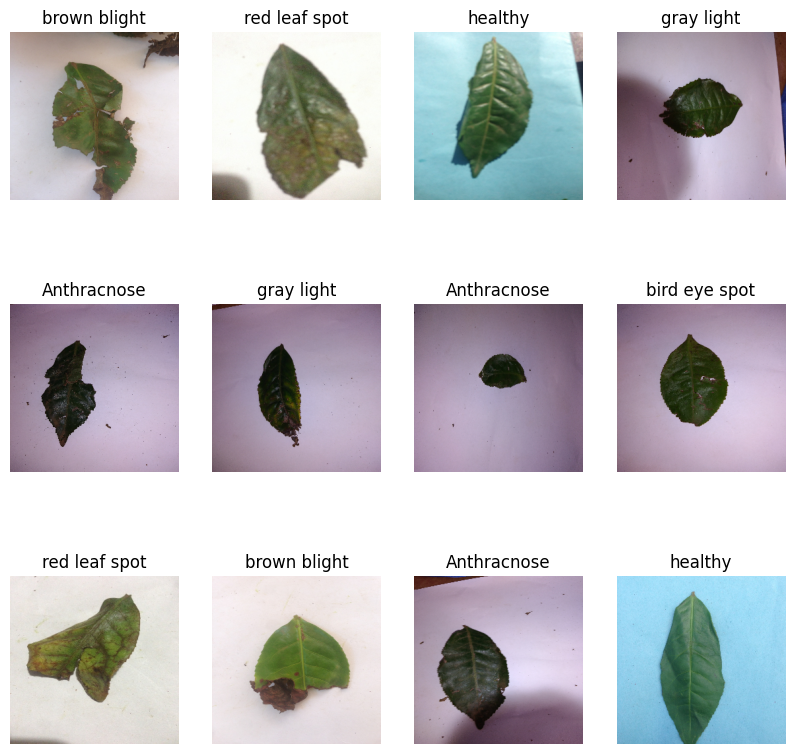

In [15]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
len(dataset)
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [17]:
train_ds = dataset.take(54)
len(train_ds)

28

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [20]:
val_size=0.1
len(dataset)*val_size

2.8000000000000003

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)
len(val_ds)
len(test_ds)

4

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [28]:
def random_hue(image, max_delta=0.2):
    return tf.image.adjust_hue(image, tf.random.uniform([], -max_delta, max_delta))

def random_brightness(image, max_delta=0.2):
    return tf.image.adjust_brightness(image, tf.random.uniform([], 1-max_delta, 1+max_delta))

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.Lambda(lambda x: random_hue(x)),
    layers.Lambda(lambda x: random_brightness(x)),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),  # Increased neurons

    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(n_classes, activation='softmax'),
])



model.build(input_shape=input_shape)

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 128)       3584      
                                                                 
 batch_normalization_7 (Bat  (32, 254, 254, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 256)       295168    
                                                                 
 batch_normalization_8 (Bat  (32, 125, 125, 256)      

In [42]:
model.compile(
     optimizer="adamax",
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#. the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    monitor='val_loss',  # Metric to monitor for improvement (e.g., 'val_loss' or 'val_accuracy')
    mode='min'  # 'min' means training will stop when the quantity monitored has stopped decreasing (e.g., val_loss)
)

# Assuming you have a validation dataset (val_ds)
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/50
20/22 [==========================>...] - ETA: 1:15 - loss: 2.3882 - accuracy: 0.3670

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:

len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'model3'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)